# Age of death prediction using linear regression

Using the WHO life expectancy dataset: https://www.kaggle.com/kumarajarshi/life-expectancy-who/data#

In [1]:
# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install pandas
!pip install seaborn
!pip install jovian --upgrade --quiet

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
# Other constants
DATASET_URL = "https://raw.githubusercontent.com/Federico-abss/pytorch_gans/master/datasets/life_expectancy_data.csv"
DATA_FILENAME = "life_expectancy_data.csv"
input_size=5
output_size=1

In [4]:
# Download the data
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)

dataframe.describe()

Using downloaded and verified file: ./life_expectancy_data.csv


,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


## Cleaning the data

Some cell names have trailing spaces or are composed of two separate names, I am gonna fix that and impose a more consistent naming scheme

In [5]:
# Renaming some column names as they contain trailing spaces.
dataframe.rename(columns={" BMI ":"BMI","Life expectancy ":"Life_Expectancy","Adult Mortality":"Adult_Mortality",
                   "infant deaths":"Infant_Deaths","percentage expenditure":"Percentage_Exp","Hepatitis B":"HepatitisB",
                  "Measles ":"Measles"," BMI ":"BMI","under-five deaths ":"Under_Five_Deaths","Diphtheria ":"Diphtheria",
                  " HIV/AIDS":"HIV/AIDS"," thinness  1-19 years":"thinness_1to19_years"," thinness 5-9 years":"thinness_5to9_years","Income composition of resources":"Income_Comp_Of_Resources",
                   "Total expenditure":"Tot_Exp"},inplace=True)
dataframe.head()

,Country,Year,Status,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Exp,HepatitisB,Measles,...,Polio,Tot_Exp,Diphtheria,HIV/AIDS,GDP,Population,thinness_1to19_years,thinness_5to9_years,Income_Comp_Of_Resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


I am gonna check if the data type is appropriate for every column

In [6]:
# Verifying whether data for each variable is according to its dataype or not.
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   2938 non-null   object 
 1   Year                      2938 non-null   int64  
 2   Status                    2938 non-null   object 
 3   Life_Expectancy           2928 non-null   float64
 4   Adult_Mortality           2928 non-null   float64
 5   Infant_Deaths             2938 non-null   int64  
 6   Alcohol                   2744 non-null   float64
 7   Percentage_Exp            2938 non-null   float64
 8   HepatitisB                2385 non-null   float64
 9   Measles                   2938 non-null   int64  
 10  BMI                       2904 non-null   float64
 11  Under_Five_Deaths         2938 non-null   int64  
 12  Polio                     2919 non-null   float64
 13  Tot_Exp                   2712 non-null   float64
 14  Diphther

The data type is consistent but many values are missing

In [7]:
# Identify percentage of null values in each column.
dataframe.isnull().sum()*100/dataframe.isnull().count()

Country                      0.000000
Year                         0.000000
Status                       0.000000
Life_Expectancy              0.340368
Adult_Mortality              0.340368
Infant_Deaths                0.000000
Alcohol                      6.603131
Percentage_Exp               0.000000
HepatitisB                  18.822328
Measles                      0.000000
BMI                          1.157250
Under_Five_Deaths            0.000000
Polio                        0.646698
Tot_Exp                      7.692308
Diphtheria                   0.646698
HIV/AIDS                     0.000000
GDP                         15.248468
Population                  22.191967
thinness_1to19_years         1.157250
thinness_5to9_years          1.157250
Income_Comp_Of_Resources     5.684139
Schooling                    5.547992
dtype: float64

In [8]:
# save the countries in a list
country_list = dataframe.Country.unique()

# list containing incomplete columns
fill_list = ['Life_Expectancy','Adult_Mortality','Alcohol','HepatitisB','BMI','Polio','Tot_Exp','Diphtheria','GDP','Population','thinness_1to19_years','thinness_5to9_years','Income_Comp_Of_Resources','Schooling']

In [9]:
# Treat null values using interpolation.
for country in country_list:
    dataframe.loc[dataframe['Country'] == country,fill_list] = dataframe.loc[dataframe['Country'] == country,fill_list].interpolate()
    
# Drop remaining null values after interpolation.
dataframe.dropna(inplace=True)

In [10]:
# Verifying null-values after applying above methods.
dataframe.isnull().sum()

Country                     0
Year                        0
Status                      0
Life_Expectancy             0
Adult_Mortality             0
Infant_Deaths               0
Alcohol                     0
Percentage_Exp              0
HepatitisB                  0
Measles                     0
BMI                         0
Under_Five_Deaths           0
Polio                       0
Tot_Exp                     0
Diphtheria                  0
HIV/AIDS                    0
GDP                         0
Population                  0
thinness_1to19_years        0
thinness_5to9_years         0
Income_Comp_Of_Resources    0
Schooling                   0
dtype: int64

## Data analysis

We are gonna look for relevant correlations to decide which columns we will use to train our model

Let's start with some general statistics about our data

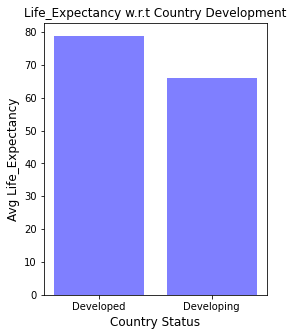

In [11]:
# Life_Expectancy w.r.t Year using bar plot.
plt.figure(figsize=(4,5))
plt.bar(dataframe.groupby('Status')['Status'].count().index,dataframe.groupby('Status')['Life_Expectancy'].mean(),color='blue',alpha=0.50)
plt.xlabel("Country Status",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy w.r.t Country Development")
plt.show()

In [12]:
round(dataframe[['Status','Life_Expectancy']].groupby(['Status']).mean(),2)

,Life_Expectancy
Status,
Developed,78.83
Developing,66.16


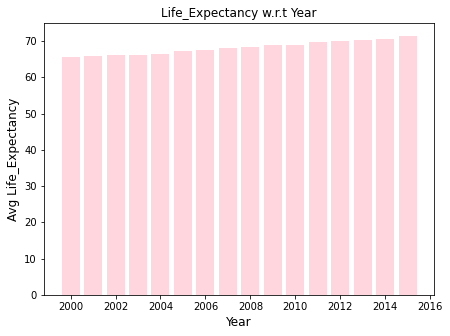

In [13]:
# Life_Expectancy w.r.t Year using bar plot.
plt.figure(figsize=(7,5))
plt.bar(dataframe.groupby('Year')['Year'].count().index,dataframe.groupby('Year')['Life_Expectancy'].mean(),color='pink',alpha=0.65)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy w.r.t Year")
plt.show()

So there is a definite difference between developed countries and the rest, but at least the life expectancy improves every year.  
Now let's try to figure out wich features affect life expectancy the most.

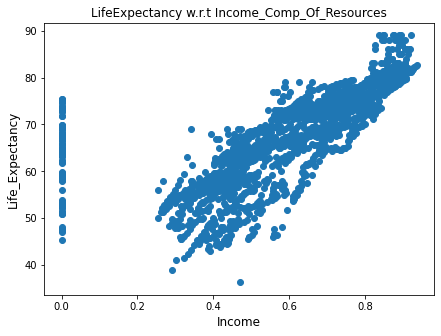

In [14]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t Income_Comp_Of_Resources")
plt.xlabel("Income",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["Income_Comp_Of_Resources"], dataframe["Life_Expectancy"])

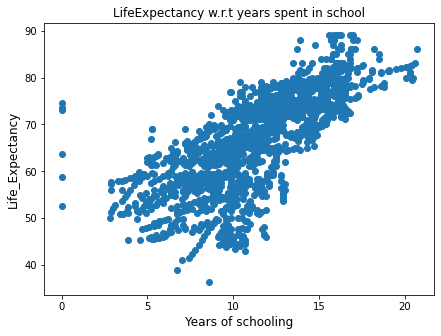

In [45]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t years spent in school")
plt.xlabel("Years of schooling",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["Schooling"], dataframe["Life_Expectancy"])

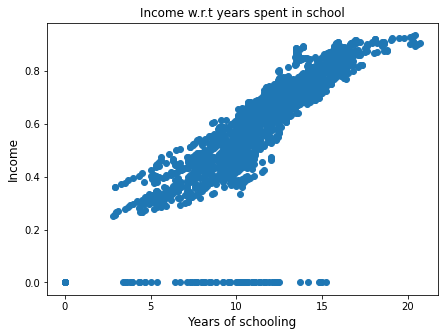

In [16]:
plt.figure(figsize=(7,5))
plt.title("Income w.r.t years spent in school")
plt.xlabel("Years of schooling",fontsize=12)
plt.ylabel("Income",fontsize=12)
plt.scatter(dataframe["Schooling"], dataframe["Income_Comp_Of_Resources"])

We can infer that schooling and income composition are positively correlated between themselves and with life expectancy

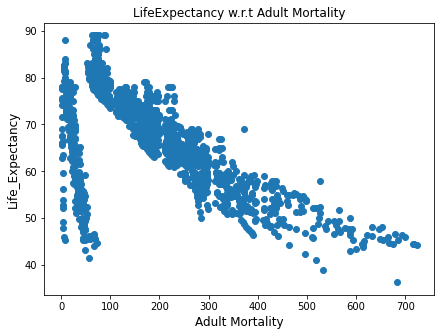

In [17]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t Adult Mortality")
plt.xlabel("Adult Mortality",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["Adult_Mortality"], dataframe["Life_Expectancy"])

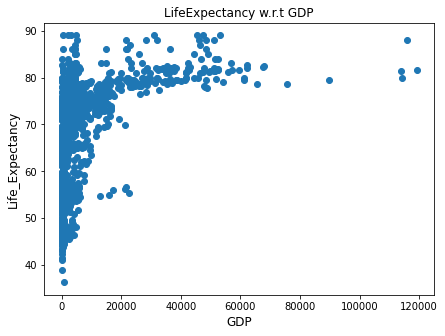

In [18]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t GDP")
plt.xlabel("GDP",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["GDP"], dataframe["Life_Expectancy"])

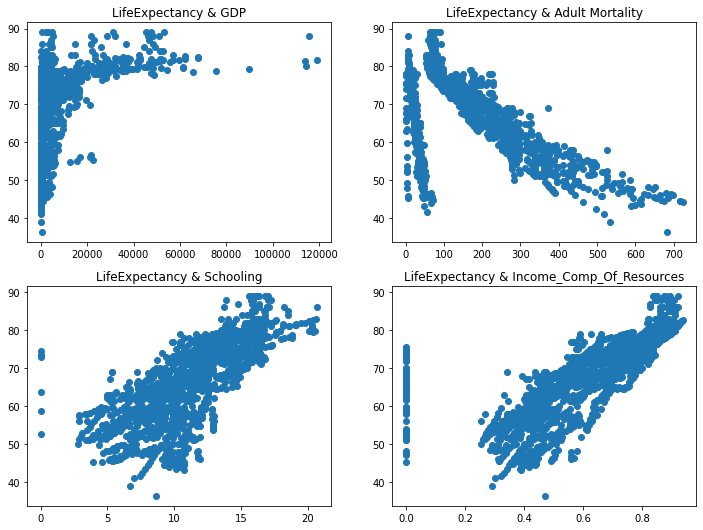

In [19]:
plt.figure(figsize=(12, 38))

plt.subplot(8,2,1)
plt.title("LifeExpectancy & GDP")
plt.scatter(dataframe["GDP"], dataframe["Life_Expectancy"])

plt.subplot(8,2,2)
plt.title("LifeExpectancy & Adult Mortality")
plt.scatter(dataframe["Adult_Mortality"], dataframe["Life_Expectancy"])

plt.subplot(8,2,3)
plt.title("LifeExpectancy & Schooling")
plt.scatter(dataframe["Schooling"], dataframe["Life_Expectancy"])

plt.subplot(8,2,4)
plt.title("LifeExpectancy & Income_Comp_Of_Resources")
plt.scatter(dataframe["Income_Comp_Of_Resources"], dataframe["Life_Expectancy"])

The four features shown above plus the status of the country will be used for building the machine learning model

## Data loaders

Now I will prepare the designated column into the data that will be used in the ml model

In [20]:
# label the designated data
num_rows = dataframe.index.size
categorical_cols = ['Status']
TARGET_COLUMN = ['Life_Expectancy']
inputs = ['Status', 'GDP', 'Adult_Mortality', 'Schooling', 'Income_Comp_Of_Resources']
dataframe[inputs].head()

,Status,GDP,Adult_Mortality,Schooling,Income_Comp_Of_Resources
0,Developing,584.259210,263.0,10.1,0.479
1,Developing,612.696514,271.0,10.0,0.476
2,Developing,631.744976,268.0,9.9,0.470
3,Developing,669.959000,272.0,9.8,0.463
4,Developing,63.537231,275.0,9.5,0.454


In [21]:
# Convert from Pandas dataframe to numpy arrays
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[inputs].to_numpy()
    targets_array = dataframe1[TARGET_COLUMN].to_numpy()
    return inputs_array, targets_array

In [22]:
inputs, targets = dataframe_to_arrays(dataframe)
inputs, targets

(array([[1.00000000e+00, 5.84259210e+02, 2.63000000e+02, 1.01000000e+01,
         4.79000000e-01],
        [1.00000000e+00, 6.12696514e+02, 2.71000000e+02, 1.00000000e+01,
         4.76000000e-01],
        [1.00000000e+00, 6.31744976e+02, 2.68000000e+02, 9.90000000e+00,
         4.70000000e-01],
        ...,
        [1.00000000e+00, 5.73483400e+01, 7.30000000e+01, 1.00000000e+01,
         4.27000000e-01],
        [1.00000000e+00, 5.48587312e+02, 6.86000000e+02, 9.80000000e+00,
         4.27000000e-01],
        [1.00000000e+00, 5.47358879e+02, 6.65000000e+02, 9.80000000e+00,
         4.34000000e-01]]), array([[65. ],
        [59.9],
        [59.9],
        ...,
        [44.8],
        [45.3],
        [46. ]]))

In [23]:
inputs.shape, targets.shape

((1987, 5), (1987, 1))

In [24]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))

val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size=2**9
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

## Model

In [25]:
class LifeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.l1_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.l1_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 50th epoch
        if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

## Training

In [26]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[1.0000e+00, 4.6971e+03, 9.7000e+01, 1.2400e+01, 7.2300e-01],
        [1.0000e+00, 5.1916e+03, 2.9900e+02, 1.1400e+01, 6.0400e-01],
        [1.0000e+00, 7.1936e+03, 1.2900e+02, 1.6300e+01, 7.8800e-01],
        ...,
        [1.0000e+00, 9.2314e+02, 5.6600e+02, 1.0800e+01, 4.5300e-01],
        [1.0000e+00, 1.4133e+03, 2.1000e+01, 1.1600e+01, 5.7200e-01],
        [1.0000e+00, 8.7315e+02, 1.4900e+02, 1.2600e+01, 6.9900e-01]])
targets: tensor([[78.6000],
        [63.0000],
        [74.8000],
        [73.7000],
        [77.0000],
        [69.4000],
        [46.0000],
        [58.5000],
        [69.3000],
        [81.0000],
        [73.0000],
        [72.3000],
        [67.4000],
        [56.7000],
        [56.7000],
        [81.7000],
        [71.0000],
        [56.1000],
        [64.4000],
        [74.6000],
        [62.7000],
        [74.4000],
        [73.4000],
        [68.1000],
        [71.3000],
        [76.9000],
        [73.9000],
        [64.1000],
        [48.1000]

In [27]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [28]:
model = LifeModel()

In [29]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1672, -0.3885, -0.0262,  0.3060,  0.4405]], requires_grad=True),
 Parameter containing:
 tensor([-0.4256], requires_grad=True)]

In [30]:
result = evaluate(model, val_loader)
result

{'val_loss': 2129.86572265625}

Now that the model has been initialized we can start the training

In [31]:
epochs = 10
learning_rate=1e-4
history = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [10], val_loss: 2107.9548


In [32]:
epochs = 1000
learning_rate=1e-4
history1 = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [50], val_loss: 1998.3151
Epoch [100], val_loss: 1888.5732
Epoch [150], val_loss: 1779.4658
Epoch [200], val_loss: 1670.2820
Epoch [250], val_loss: 1560.8851
Epoch [300], val_loss: 1451.8232
Epoch [350], val_loss: 1342.9438
Epoch [400], val_loss: 1234.3456
Epoch [450], val_loss: 1125.6744
Epoch [500], val_loss: 1017.4001
Epoch [550], val_loss: 909.6881
Epoch [600], val_loss: 802.0073
Epoch [650], val_loss: 694.6505
Epoch [700], val_loss: 588.4855
Epoch [750], val_loss: 484.1162
Epoch [800], val_loss: 379.0567
Epoch [850], val_loss: 276.0617
Epoch [900], val_loss: 175.0123
Epoch [950], val_loss: 78.7063
Epoch [1000], val_loss: 32.3030


In [33]:
epochs = 1000
learning_rate=5e-3
history2 = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [50], val_loss: 23.4212
Epoch [100], val_loss: 16.9695
Epoch [150], val_loss: 13.8123
Epoch [200], val_loss: 10.0411
Epoch [250], val_loss: 8.6003
Epoch [300], val_loss: 7.3694
Epoch [350], val_loss: 8.6298
Epoch [400], val_loss: 7.6554
Epoch [450], val_loss: 7.1300
Epoch [500], val_loss: 7.0554
Epoch [550], val_loss: 6.8726
Epoch [600], val_loss: 8.4802
Epoch [650], val_loss: 7.3451
Epoch [700], val_loss: 10.1619
Epoch [750], val_loss: 7.9844
Epoch [800], val_loss: 11.3588
Epoch [850], val_loss: 8.9760
Epoch [900], val_loss: 6.7803
Epoch [950], val_loss: 7.2850
Epoch [1000], val_loss: 6.5803


In [34]:
epochs = 10000
learning_rate=1e-5
history3 = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [50], val_loss: 6.2930
Epoch [100], val_loss: 6.2880
Epoch [150], val_loss: 6.2851
Epoch [200], val_loss: 6.2797
Epoch [250], val_loss: 6.2940
Epoch [300], val_loss: 6.2812
Epoch [350], val_loss: 6.2734
Epoch [400], val_loss: 6.2956
Epoch [450], val_loss: 6.2789
Epoch [500], val_loss: 6.2865
Epoch [550], val_loss: 6.2820
Epoch [600], val_loss: 6.2940
Epoch [650], val_loss: 6.2952
Epoch [700], val_loss: 6.2663
Epoch [750], val_loss: 6.2750
Epoch [800], val_loss: 6.2784
Epoch [850], val_loss: 6.2671
Epoch [900], val_loss: 6.2922
Epoch [950], val_loss: 6.2659
Epoch [1000], val_loss: 6.2667
Epoch [1050], val_loss: 6.2764
Epoch [1100], val_loss: 6.2753
Epoch [1150], val_loss: 6.2849
Epoch [1200], val_loss: 6.2723
Epoch [1250], val_loss: 6.2789
Epoch [1300], val_loss: 6.2882
Epoch [1350], val_loss: 6.2893
Epoch [1400], val_loss: 6.2689
Epoch [1450], val_loss: 6.2853
Epoch [1500], val_loss: 6.2799
Epoch [1550], val_loss: 6.2710
Epoch [1600], val_loss: 6.2824
Epoch [1650], val_loss: 6.27

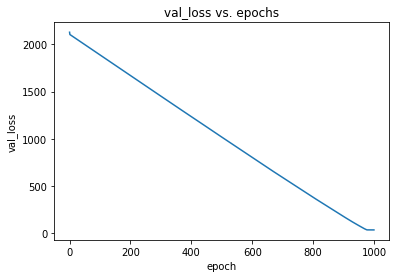

In [48]:
losses = [r['val_loss'] for r in [result] + history1]
plt.plot(losses, '-')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Predictions

In [36]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [37]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([1.0000e+00, 7.1364e+02, 5.2700e+02, 1.0000e+01, 4.3600e-01])
Target:  52.400001525878906
Prediction: 58.3087158203125


In [38]:
x, target = val_ds[17]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([1.0000e+00, 2.9691e+04, 9.9000e+01, 1.5400e+01, 8.5200e-01])
Target:  79.30000305175781
Prediction: 85.18712615966797


In [39]:
x, target = val_ds[23]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([1.0000e+00, 9.3334e+02, 1.2300e+02, 1.2300e+01, 7.3100e-01])
Target:  76.0
Prediction: 71.99646759033203


Overall the model seems to be quite accurate in its prediction, we can call it a success

In [49]:
# final parameters
list(model.parameters())

[Parameter containing:
 tensor([[ 1.0620e+01,  1.3200e-05, -7.6577e-03,  3.8408e+00,  5.9570e+00]],
        requires_grad=True), Parameter containing:
 tensor([10.7100], requires_grad=True)]

## Save and upload

In [50]:
torch.save(model.state_dict(), 'life-expectancy.pth')

In [ ]:
jovian.commit(project='life-expectancy-linear', environment=None, outputs=['life-expectancy.pth'])
jovian.commit(project='life-expectancy-linear', environment=None, outputs=['life-expectancy.pth']) # Kaggle commit fails sometimes, so try again..

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "federico-abss/life-expectancy-linear" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Committed successfully! https://jovian.ml/federico-abss/life-expectancy-linear


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
